In [2]:
from pathlib import Path

root_dir = Path("../IXI_dataset/IXI_raw/")
seqs = ["T1", "T2", "PD"]

subjects_dict = {}

for seq_path in root_dir.iterdir():

    if not seq_path.is_dir():
        continue
    seq_name = seq_path.name.split("-")[-1]
    # print(f"Sequence: {seq_name}")

    if seq_name not in seqs:
        continue

    print(f"Number of subjects in {seq_name}: ", len(list(seq_path.iterdir())))
    subjects_dict[seq_name] = [
        i.name.split(f"{seq_name}.nii.gz")[0] for i in list(seq_path.iterdir())
    ]

Number of subjects in PD:  578
Number of subjects in T1:  581
Number of subjects in T2:  578


In [2]:
print(f"T1-T2: {set(subjects_dict['T1']) - set(subjects_dict['T2'])}")
print(f"T2-T1: {set(subjects_dict['T2']) - set(subjects_dict['T1'])}")

T1-T2: {'IXI116-Guys-0739-', 'IXI182-Guys-0792-', 'IXI309-IOP-0897-', 'IXI500-Guys-1017-'}
T2-T1: {'IXI580-IOP-1157-'}


In [3]:
print(f"T2-PD: {set(subjects_dict['T2']) - set(subjects_dict['PD'])}")

T2-PD: set()


In [4]:
print(len(set(subjects_dict['T1'])&set(subjects_dict['T2'])&set(subjects_dict['PD'])))

577


T1 & PD have the same subjects
T1, T2, PD share 577 same subjects

below shows the stats about spacing

In [18]:
# test for loader
from monai.transforms import LoadImage
from monai.data.utils import affine_to_spacing
loader = LoadImage()
img = loader(root_dir/"IXI-T1" / "IXI517-IOP-1144-T1.nii.gz")
print(affine_to_spacing(img.affine)[0])


tensor(0.9375, dtype=torch.float64)


Spacing for T2 subject ../IXI_dataset/IXI_raw/IXI-T2/IXI014-HH-1236-T2.nii.gz: (0.8984375204972158, 4.977778057095752)


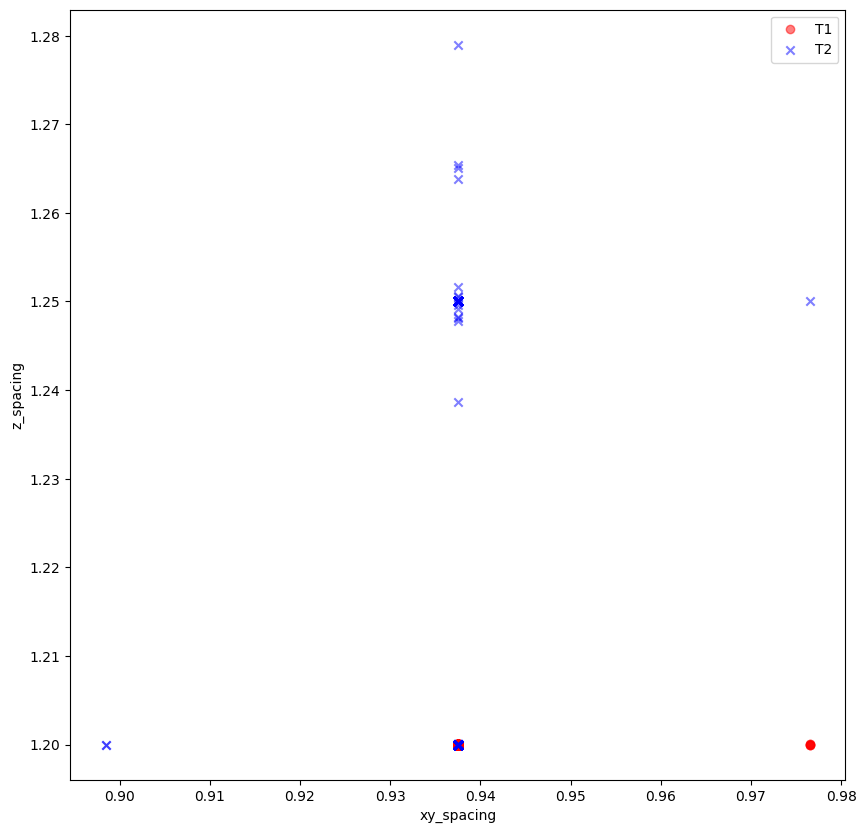

In [24]:
import random
from monai.transforms import LoadImage
from monai.data.utils import affine_to_spacing
import matplotlib.pyplot as plt

loader = LoadImage()

def get_spacing(subject):
    _img = loader(subject)
    _spacing = affine_to_spacing(_img.affine)
    return _spacing[0].item(),_spacing[-1].item()

xy_spacings = {"T1": [], "T2": []}
z_spacings = {"T1": [], "T2": []}


for seq in ["T1", "T2"]:
    for subject in (root_dir/f"IXI-{seq}").iterdir():

        xy_spacing,z_spacing = get_spacing(subject)
        if z_spacing > 2.0:
            print(f"Spacing for {seq} subject {subject}: {xy_spacing,z_spacing}")
            continue
        xy_spacings[seq].append(xy_spacing)
        z_spacings[seq].append(z_spacing)
        # print(f"Spacing for {seq} subject {subject}: {spacing}")
    # subjects_dict[seq] = [f"{seq}_{i}" for i in range(10)]


# 创建散点图
plt.figure(figsize=(10, 10))
plt.scatter(xy_spacings["T1"], z_spacings["T1"], label="T1",color="red",alpha=0.5)
plt.scatter(xy_spacings["T2"], z_spacings["T2"], label="T2",color="blue",marker="x",alpha=0.5)
plt.xlabel("xy_spacing")
plt.ylabel("z_spacing")
plt.legend()
plt.show()

Exclude outier: Spacing for T2 subject ../IXI_dataset/IXI_raw/IXI-T2/IXI014-HH-1236-T2.nii.gz: (0.8984375204972158, 4.977778057095752)
T1, T2, PD share 576 same subjects

Inspect affine mattrix between T2 & PD

In [25]:
def get_affine_matrix(subject):
    _img = loader(subject)
    return _img.affine

eps = 1e-6

for subject in (root_dir/f"IXI-T2").iterdir():
    affine_T2 = get_affine_matrix(subject)
    subject_PD = root_dir/f"IXI-PD"/f"{subject.name.split('T2.nii.gz')[0]}PD.nii.gz"
    affine_PD = get_affine_matrix(subject_PD)
    if (affine_T2-affine_PD).sum()>eps:
        print(f"Affine matrix for T2 and PD subject {subject} is not the same.")
        print(affine_T2)
        print(affine_PD)

Affine matrix for T2 and PD subject ../IXI_dataset/IXI_raw/IXI-T2/IXI014-HH-1236-T2.nii.gz is not the same.
tensor([[-8.9231e-01, -8.0259e-02, -3.7327e-01,  1.2928e+02],
        [-8.5052e-02,  8.9213e-01,  3.5280e-01, -9.8736e+01],
        [-6.1210e-02, -6.9620e-02,  4.9512e+00, -2.7691e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
tensor([[-8.9231e-01, -8.0259e-02, -3.5994e-01,  1.2928e+02],
        [-8.5052e-02,  8.9213e-01,  3.4020e-01, -9.8736e+01],
        [-6.1210e-02, -6.9620e-02,  4.7744e+00, -2.7691e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
